In [1]:
import sys
sys.path.append("/home/adityas/UGA/SensorWeb/scripts/Summer2018/code")

from pathlib import Path
import pandas
import matplotlib.pyplot as plotter
import numpy
import seaborn
from scipy.signal import *

Import data loaders and all

In [2]:
from model.data_loader import DataLoader

In [3]:
files = list(Path("../data/single_test/").iterdir())
files = sorted(files, key=lambda x: int(str(x).split("/")[-1].split(".")[0].split("_")[-1]))
files[:10]

[PosixPath('../data/single_test/run_0.csv'),
 PosixPath('../data/single_test/run_1.csv'),
 PosixPath('../data/single_test/run_2.csv'),
 PosixPath('../data/single_test/run_3.csv'),
 PosixPath('../data/single_test/run_4.csv'),
 PosixPath('../data/single_test/run_5.csv'),
 PosixPath('../data/single_test/run_6.csv'),
 PosixPath('../data/single_test/run_7.csv'),
 PosixPath('../data/single_test/run_8.csv'),
 PosixPath('../data/single_test/run_9.csv')]

Initialize data loader

## Data stats

In [4]:
dataloader = DataLoader(files)

Print some statistics to look at distributions

        cpu  disk   network    energy
0  0.492196   0.0  0.000000  0.543585
1  0.862552   0.0  0.000000  0.576381
2  1.000000   0.0  0.123285  0.601000
3  1.000000   0.0  0.000474  0.588601
4  0.849604   0.0  0.000000  0.575235


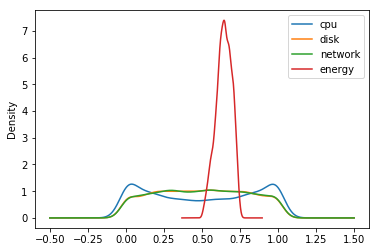

In [5]:
test_data = dataloader[0]
print(test_data.head(5))
test_data.plot(kind="density")
plotter.legend()
plotter.show()

Have a peek at the target function

In [6]:
!head ../scripts/exp.log -n 15

DEBUG:CPU:CPU component initialized
DEBUG:DiskIO:Disk IO component initialized
DEBUG:Network:Networking component initialized
DEBUG:CPU:CPU component initialized
DEBUG:DiskIO:Disk IO component initialized
DEBUG:Network:Networking component initialized
DEBUG:CPU:CPU component initialized
DEBUG:DiskIO:Disk IO component initialized
DEBUG:Network:Networking component initialized
INFO:HighSensitivityLinearEM:Energy meter init with factors cpu:0.24792518649303633 + disk:0.2550646624326527 + net:0.2542521020480565
INFO:Device:Device initialised
DEBUG:Device:Device in state compute
DEBUG:Device:Device in state net_send
DEBUG:Device:Device in state read
DEBUG:Device:Device in state compute


Take a look at the waveforms

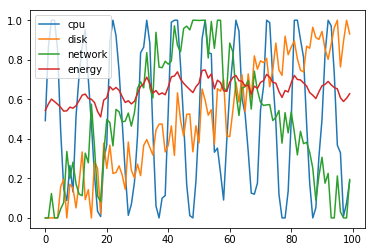

In [7]:
test_data[:100].plot()
plotter.legend()
plotter.show()

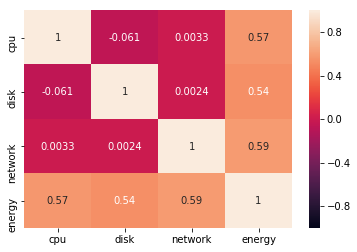

In [8]:
corr = test_data.corr()
seaborn.heatmap(corr, annot=True, vmin=-1.0)
plotter.show()

Clean up

In [9]:
del test_data

## Learn function

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

In [11]:
regressor = MLPRegressor(hidden_layer_sizes=(50,5), activation='logistic')

In [12]:
def make_batch(X, y, window=5):
    
    _X = []
    _y = []
    
    for i in range(X.shape[0]-(window-1)):
        _X.append(X[i: i+window, :].ravel())
        _y.append(y[i+int(window/2)])
    
    return numpy.array(_X), numpy.array(_y)
        

In [13]:
for i in range(1):
    for batch in range(len(dataloader)):
        data = dataloader[i]
        X = data["energy"].as_matrix().reshape(-1, 1)
        y = data["cpu"].as_matrix().reshape(-1, 1)
        
        batchX ,batchy = make_batch(X, y.ravel(), window=101)
        
        #print(X.shape)
        #print(y.shape)
        
        regressor.partial_fit(batchX, batchy)
        
        print(f"For epoch {i} batch {batch} score is {mean_absolute_error(y_pred=regressor.predict(batchX), y_true=batchy)}")

#print(f"Regression coefficients are {regressor.coefs_}")
#print(f"Bias {regressor.intercepts_}")

For epoch 0 batch 0 score is 0.3135425582016178
For epoch 0 batch 1 score is 0.3124826917536445
For epoch 0 batch 2 score is 0.3111592540339135
For epoch 0 batch 3 score is 0.30879686726813493
For epoch 0 batch 4 score is 0.30450272386140154
For epoch 0 batch 5 score is 0.29637808426985474
For epoch 0 batch 6 score is 0.28325914631609866
For epoch 0 batch 7 score is 0.26048433477590116
For epoch 0 batch 8 score is 0.22277605514614038
For epoch 0 batch 9 score is 0.17162053857559528
For epoch 0 batch 10 score is 0.11970142490981725
For epoch 0 batch 11 score is 0.08620806930940729
For epoch 0 batch 12 score is 0.07589913562607234
For epoch 0 batch 13 score is 0.0725905506526622
For epoch 0 batch 14 score is 0.07170610328299303
For epoch 0 batch 15 score is 0.07187213190976581
For epoch 0 batch 16 score is 0.075000122757448
For epoch 0 batch 17 score is 0.07174654483994158
For epoch 0 batch 18 score is 0.07135285928850936
For epoch 0 batch 19 score is 0.07148313342519239
For epoch 0 batc

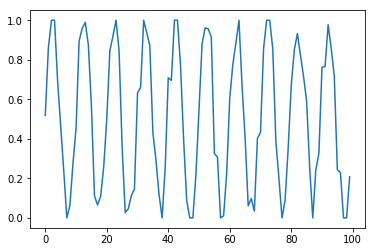

In [14]:
data = dataloader[-1]
X = data["energy"].as_matrix().reshape(-1, 1)
y = data["cpu"].as_matrix().reshape(-1, 1)
batchX ,batchy = make_batch(X, y, window=101)

plotter.plot(batchy[:100])
plotter.show()

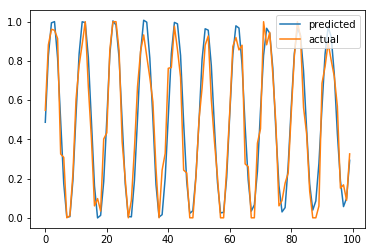

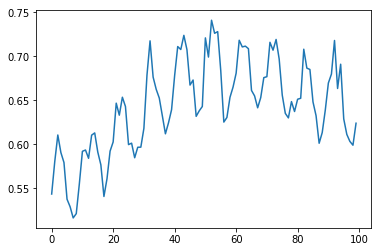

(9900,)
(9900,)


In [15]:
prediction = regressor.predict(batchX)
y = y[y.shape[0]-prediction.shape[0]:].ravel()
plotter.plot(prediction[3000:3100], label="predicted")
plotter.plot(y[:100], label="actual")
plotter.legend()
plotter.show()

plotter.plot(X[:100])
plotter.show()

print(prediction.shape)
print(y.shape)